In [1]:
import pandas as pd
import sklearn
from sklearn.cluster import *
import paddle
from paddlenlp.transformers import BertTokenizer, BertModel
import numpy as np
import  random

_list=pd.read_csv(r'D:\python_common\基本语料库\数据集_10类\online_shopping_10_cats.csv',encoding='utf-8')
_list.columns=['cat','label','review']

_list=_list.groupby('cat').head(200)
# _list=_list.groupby('label').head(200)

_list=_list[(_list['cat'].isin(['书籍','平板','水果','洗发水','衣服'])) & (_list['label'] == 1)]
print(_list.shape)
class Mybert():
    def __init__(self):
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
    def get(self,text):
        tokenized_text = self.tokenizer.tokenize(text)
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = paddle.to_tensor([indexed_tokens])
        self.bert.eval()
        with paddle.no_grad():
            outputs = self.bert(tokens_tensor.cuda())
        return outputs[1].cpu().numpy()[0]
mybert=Mybert()

vectors=np.array([mybert.get(each) for each in _list['review']]).astype(np.float32)
# 把字符转为数字
cats=np.array(_list['cat'].apply(lambda x: ['书籍','平板','水果','洗发水','衣服'].index(x)).astype(np.int64).tolist())
# cats=np.array(_list['label'])
print(vectors.shape)
print(list(set(cats.tolist())))

[2023-09-09 22:08:07,883] [    INFO] - Already cached C:\Users\93461\.paddlenlp\models\bert-base-chinese\bert-base-chinese.pdparams


(1000, 3)
1    1000
Name: label, dtype: int64


[2023-09-09 22:08:16,920] [    INFO] - Weights from pretrained model not used in BertModel: ['cls.predictions.decoder_weight', 'cls.predictions.decoder_bias', 'cls.predictions.transform.weight', 'cls.predictions.transform.bias', 'cls.predictions.layer_norm.weight', 'cls.predictions.layer_norm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
[2023-09-09 22:08:17,364] [    INFO] - Already cached C:\Users\93461\.paddlenlp\models\bert-base-chinese\bert-base-chinese-vocab.txt
[2023-09-09 22:08:17,384] [    INFO] - tokenizer config file saved in C:\Users\93461\.paddlenlp\models\bert-base-chinese\tokenizer_config.json
[2023-09-09 22:08:17,387] [    INFO] - Special tokens file saved in C:\Users\93461\.paddlenlp\models\bert-base-chinese\special_tokens_map.json


(1000, 768)
[0, 1, 2, 3, 4]


In [7]:
# 降维
from sklearn.decomposition import PCA
from umap import UMAP
vectors_pca=PCA(n_components=3).fit_transform(vectors)
vectors_umap=UMAP(n_components=3,
                  metric='cosine',
                    n_neighbors=10,
                    min_dist=0.01,
                    random_state=42
                  ).fit_transform(vectors)

In [12]:
# 相似性度量
import numpy as np
from sklearn.metrics import  silhouette_score
# 向量内积
def sim1(x,y):
    return np.dot(x,y)
# 夹角余弦
def sim2(x,y):
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
# RBF核
def sim3(x,y):
    # return np.exp(-np.linalg.norm(x-y)*(1/len(x[0:])))
    return np.exp(-np.linalg.norm(x-y)*(0.9))

VEC=vectors

# 相似性
# for sim in [sim1,sim2,sim3]:
for sim in [sim1,sim2]:
    SIM_VEC=np.zeros((len(VEC),len(VEC)))
    for i in range(0,len(VEC)-1):
        for j in range(i+1,len(VEC)):
            SIM_VEC[i][j]=sim(VEC[i],VEC[j])
            SIM_VEC[j][i]=SIM_VEC[i][j]
    # 如果是sim1的话需要归一化
    if sim == sim1 or sim == sim2:
        SIM_VEC = (SIM_VEC - np.min(SIM_VEC)) / (np.max(SIM_VEC) - np.min(SIM_VEC))
    np.fill_diagonal(SIM_VEC, 0)
    print(silhouette_score(SIM_VEC, cats, metric='precomputed'))


相似度相似度
0.031443620725514265
相似度相似度
0.012538024372007826


In [0]:

# 可视化
import matplotlib.pyplot as plt

# import pandas as pd
# import numpy as np
# import plotly.express as px
# def chart_plotly(X, y):
#     arr_concat = np.concatenate((X, y.reshape(y.shape[0], 1)), axis=1)
#     df = pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
#     df['label'] = df['label'].astype(int)
#     df.sort_values(by='label', axis=0, ascending=True, inplace=True)
#     fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=600, width=650)
#     fig.update_layout(title_text='UMAP',
#                       showlegend=True,
#                       legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
#                       scene_camera=dict(up=dict(x=0, y=0, z=1),
#                                         center=dict(x=0, y=0, z=-0.1),
#                                         eye=dict(x=1.5, y=-1.4, z=0.5)),
#                       margin=dict(l=0, r=0, b=0, t=0),
#                       scene=dict(xaxis=dict(backgroundcolor='white',
#                                             color='white',
#                                             # gridcolor='#f0f0f0',
#                                             title_font=dict(size=10),
#                                             tickfont=dict(size=10),
#                                             ),
#                                  yaxis=dict(backgroundcolor='white',
#                                             color='white',
#                                             # gridcolor='#f0f0f0',
#                                             title_font=dict(size=10),
#                                             tickfont=dict(size=10),
#                                             ),
#                                  zaxis=dict(backgroundcolor='lightgrey',
#                                             color='white',
#                                             # gridcolor='#f0f0f0',
#                                             title_font=dict(size=10),
#                                             tickfont=dict(size=10),
#                                             )))
#     # Update marker size
#     fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
#     fig.show()
# chart_plotly(VEC, cats)

相似度相似度
-0.0152602769724724
相似度相似度
相似度相似度
-0.036538422324186345
相似度相似度
相似度相似度
-0.061890207536136596
相似度相似度
相似度相似度
-0.0888686279810951
相似度相似度
相似度相似度
-0.11424190153873331
相似度相似度
相似度相似度
-0.13543264619446546
相似度相似度
相似度相似度
-0.1507294803707861
相似度相似度
相似度相似度
-0.16130106625273335
相似度相似度
相似度相似度
-0.16759752212516268
相似度相似度
相似度相似度
-0.1707596801825513
相似度相似度
相似度相似度
-0.1719357968702414
相似度相似度
相似度相似度
-0.17120300203307579
相似度相似度
相似度相似度
-0.16931490005303773
相似度相似度
相似度相似度
-0.16673814913681542
相似度相似度
相似度相似度
-0.16365450629150402
相似度相似度
相似度相似度
-0.1601940166735687
相似度相似度
相似度相似度
-0.15661291540126498
相似度相似度
相似度相似度
-0.1531583355479679
相似度相似度
相似度相似度
-0.1497913401687035
相似度相似度


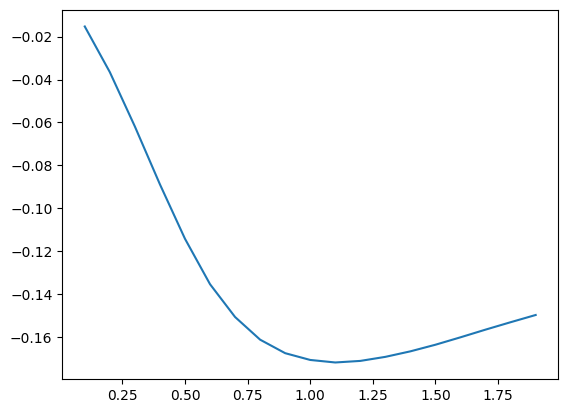

In [11]:

x=[]
y=[]
for m in np.arange(0.1,2,0.1):
    # RBF核
    def sim3(x,y,m=m):
        return np.exp(-np.linalg.norm(x-y)*m)

    SIM_VEC=np.zeros((len(VEC),len(VEC)))
    for i in range(0,len(VEC)-1):
        for j in range(i+1,len(VEC)):
            SIM_VEC[i][j]=sim3(VEC[i],VEC[j])
            SIM_VEC[j][i]=SIM_VEC[i][j]
    np.fill_diagonal(SIM_VEC, 0)
    x.append(m)
    print(silhouette_score(SIM_VEC, cats, metric='precomputed'))
    y.append(silhouette_score(SIM_VEC, cats, metric='precomputed'))

import matplotlib.pyplot as plt
plt.plot(x,y)